### Comparador de Tensão CMOS Calibrado por SGA

O objetivo é calibrar um comparador de tensão envolvendo dois transistores e um inversor. A seguir o circuito a ser calibrado:

![title](./comp_img.png)

In [224]:
import matplotlib.pyplot as plt
import PySpice
import PySpice.Logging.Logging as Logging
import numpy as np

logger = Logging.setup_logging()

from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Probe.Plot import plot
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

In [225]:
Steps = 100
Vdd = 3.3

In [226]:
def rmse_out(vin, vout, target):
    target_wave = (vin > target)*Vdd
    
    return np.sqrt(np.mean((vout-target_wave)**2))
    

In [227]:
def simulate(x):
    circuit = Circuit('NMOS Transistor')
    circuit.include('./Libs/CMOS35.lib')
    
    Bias = x[4]

    # V <name> <positive node> <negative node> <value>
    VVdd = circuit.V('vdd', 'vddnode', circuit.gnd, u_V(Vdd))
    VBias = circuit.V('vbias', 'vbiasnode', circuit.gnd, u_V(Bias))
    Vin = circuit.SinusoidalVoltageSource('vinp', 'vin', circuit.gnd, amplitude=u_V(Vdd/2), frequency=u_Hz(InFreq), offset=u_V(Vdd/2))

    # M <name> <drain node> <gate node> <source node> <bulk/substrate node>
    circuit.MOSFET(1, 'vout', 'vcomp', circuit.gnd, circuit.gnd, model='MODN', w=1e-6,l=1e-6)
    circuit.MOSFET(2, 'vout', 'vcomp', 'vddnode', 'vddnode', model='MODP', w=3e-6,l=1e-6)
    circuit.MOSFET(3, 'vcomp', 'vbiasnode', circuit.gnd, circuit.gnd, model='MODN', w=x[0]*1e-6,l=x[1]*1e-6)
    circuit.MOSFET(4, 'vcomp', 'vin', 'vddnode', 'vddnode', model='MODP', w=x[2]*1e-6,l=x[3]*1e-6);
    
    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    analysis = simulator.transient(step_time=Vin.period/Steps, end_time=Vin.period*2.1)
    
    return analysis['vin'].as_ndarray(), analysis['vout'].as_ndarray()

In [228]:
def calc_fitness(x, target):
    vin, vout = simulate(x)
   
    rmse = rmse_out(vin, vout, target)
    return 1/rmse

In [229]:
def SGA (Xs, gens, k, mu, max_inc, target, n_params, limits, mut_rate):
    parents = np.zeros((k, n_params+1))
    p1 = np.zeros((n_params+1,))
    p2 = np.zeros((n_params+1,))
    Jhist = np.zeros((gens,))
    scores = np.zeros((mu,))
    freqs = np.zeros((mu,))
    for gen in range(0, gens):
        # Pontuacao  
#         print("Gen: ", gen)
#         print(Xs)
        for i in range(0, mu):
            scores[i] = calc_fitness(Xs[i, :], target)
        
        
        maxIdx = np.argmax(scores)
#         print(scores)
        Jhist[gen] = scores[maxIdx]
        
        # Selecao dos Pais
        topIdx = np.argsort(scores)[::-1]

        for i in range(0, k):
            for j in range(0, n_params+1):
                parents[i, j] = Xs[topIdx[i], j]
        
        # Crossover
        for i in range(0, mu):
            r1 = np.random.randint(0, k)
            r2 = np.random.randint(0, k)
            for j in range(0, n_params+1):
                Xs[i, j] = parents[r1, j]/2 + parents[r2, j]/2
        
        # Mutacao
        for i in range(0, mu):
            for j in range(0, n_params):
                if np.random.rand() <= mut_rate:
                    increment = np.random.uniform(-max_inc[0], max_inc[0])
                    Xs[i, j] += increment
                    if Xs[i, j] < limits[0, 0] or Xs[i, j] > limits[0, 1]:
                        Xs[i, j] -= 2*increment
                        
            if np.random.rand() <= mut_rate:
                increment = np.random.uniform(-max_inc[1], max_inc[1])
                Xs[i, n_params] += increment
                if Xs[i, n_params] < limits[1, 0] or Xs[i, n_params] > limits[1, 1]:
                    Xs[i, n_params] -= 2*increment
#             Xs[i, n_params] = 1
#             Xs[i, 0] = 1
#             Xs[i, 1] = 1
#             Xs[i, 2] = 1
                    
        
    # Pontuacao
    for i in range(0, mu):
        scores[i] = calc_fitness(Xs[i, :], target)
    maxIdx = np.argmax(scores)
    return scores[maxIdx], Xs[maxIdx, :], Jhist

In [230]:
runs = 10
mu = 10
gens = 50
k = 2
mut_rate = 0.8
target = 1
n_params = 4
max_inc = [0.3, 0.1]
limits = np.array([[1, 10], [0.5, Vdd]])

allX = np.zeros((runs, n_params+1))
allS = np.zeros((runs, 1))
allJ = np.zeros((runs, gens))
progress = 0
progress_t = 0

for j in range(0, runs):
    np.random.seed(j)

    Xs = np.random.uniform(limits[0, 0],limits[0, 1], (mu, n_params+1))
    Xs[:, n_params] = np.random.uniform(limits[1, 0],limits[1, 1], (1, mu))
     
    minS, minX, Jhist = SGA(Xs, gens, k, mu, max_inc, target, n_params, limits, mut_rate)
#     print(minX)
    allX[j, :] = minX
    allS[j] = minS
#     print(minS)
    allJ[j, :] = Jhist.ravel()
    progress += 1
    progress_t += 1
    
    if(progress >= runs/20):
        progress = 0
        print("Progresso: ", progress_t/runs * 100,"%")


Progresso:  10.0 %
Progresso:  20.0 %
Progresso:  30.0 %
Progresso:  40.0 %
Progresso:  50.0 %
Progresso:  60.0 %
Progresso:  70.0 %
Progresso:  80.0 %
Progresso:  90.0 %
Progresso:  100.0 %


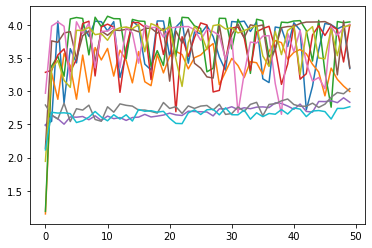

In [231]:
for i in range(0, runs):
    plt.plot(allJ[i, :])
plt.show()

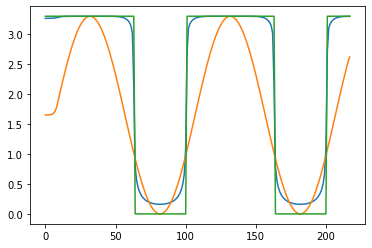

1.0356250260081532
4.052336090153835
[4.8751628  4.41330991 8.59207637 8.2671983  1.18549892]


In [232]:
bestX = allX[np.argmax(allS), :]


vin, vout = simulate(bestX)
plt.plot(vout)
plt.plot(vin)
target_wave = (vin > target)*Vdd
plt.plot(target_wave)

# print(1/np.sqrt(np.mean((vout-target_wave)**2)))
plt.show()
print(calc_fitness(x2, target))
print(calc_fitness(bestX, target))
print(bestX)